In [ ]:
"""IBOR User Journey

A day in the life of an IBOR using LUSID

Attributes
----------
instruments
quotes
transaction configuration
sub-holding keys
aggregation
corporate actions
cocoon
aggregation
results store
valuation reconciliation
"""

### Import Libraries

In [1]:
from datetime import datetime, timedelta
import copy
import json
import os
import socket

import pandas as pd
import numpy as np
import pytz
import matplotlib.pyplot as plt

from lusid.utilities import ApiClientFactory

from lusid.api import (
    InstrumentsApi, 
    TransactionPortfoliosApi, 
    CorporateActionSourcesApi, 
    AggregationApi, 
    PortfoliosApi,
    DerivedTransactionPortfoliosApi,
    ReconciliationsApi,
    ResultsApi,
    SystemConfigurationApi
)

from lusid.models import (
    CreateTransactionPortfolioRequest, 
    CreateCorporateActionSourceRequest, 
    ResourceId, 
    CreatePortfolioDetails,
    UpsertCorporateActionRequest, 
    CorporateActionTransition,
    CorporateActionTransitionComponentRequest,
    ConfigurationRecipe, 
    MarketContext, 
    MarketDataKeyRule, 
    MarketContextSuppliers, 
    MarketOptions,
    AggregationRequest,
    AggregateSpec, 
    CreateDerivedTransactionPortfolioRequest,
    ValuationsReconciliationRequest,
    ValuationReconciliationRequest,
    CreateResults,
    SideConfigurationDataRequest,
    TransactionConfigurationTypeAlias, 
    PropertyValue, 
    PerpetualProperty, 
    TransactionConfigurationMovementDataRequest, 
    TransactionConfigurationDataRequest
)

from lusidjam import RefreshingToken
from lusidtools.cocoon.cocoon import load_from_data_frame
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame
from lusidtools.cocoon.transaction_type_upload import create_transaction_type_configuration
from lusidtools.cocoon.utilities import create_scope_id
from lusid.exceptions import ApiException

from lusidtools.cocoon.cocoon_printer import (
    format_instruments_response,
    format_quotes_response,
    format_portfolios_response,
    format_transactions_response,
    format_holdings_response
)

### Set Up Top Level Variables

In [2]:
# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

api_factory = ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path,
    app_name="LusidJupyterNotebook")

scope = "IBORUserJourney"
ibor_portfolio_code = "IBOR" + "-" + create_scope_id()
ibor_portfolio_creation_date = datetime(2015, 1, 1, tzinfo=pytz.UTC)

# The timezone that you are operating in
us_tz = pytz.timezone('America/New_York')

## Day 1 - 28th of April 2020

## 9am - Start with Accounting Book of Record (ABOR)

Will ensure that you have the following loaded internally to support the start of day ABOR

- Instruments
- Market Data Quotes

Then you load in the start of day ABOR

- Create Portfolio (once off, usually already done)
- Set Holdings

#### Instruments

In [3]:
# Load and display instruments from CSV file
instruments = pd.read_csv("./data/IBORFlows_Securities.csv")
instruments.head(n=15)

,Name,GICSSector,GICSIndustry,CountryCode,FIGI,ISIN,ClientInternal,SecurityType,ExchangeCode,Ticker,Coupon,PaymentFrequency,ParValue,ConversionRatio,ExerciseDate,CounterParty,ReplacementCost
0,AMAZON.COM INC,Consumer Discretionary,Internet & Direct Marketing Retail,US,BBG000BVPV84,US0231351067,NaN,Common Stock,US,AMZN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GENERAL ELECTRIC CO,Industrials,Industrial Conglomerates,US,BBG000BK6MB5,US3696041033,NaN,Common Stock,US,GE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,APPLE INC,Information Technology,"Technology Hardware, Storage & Peripherals",US,BBG000B9XRY4,US0378331005,NaN,Common Stock,US,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MICROSOFT CORP,Information Technology,Software,US,BBG000BPH459,US5949181045,NaN,Common Stock,US,MSFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FACEBOOK INC-CLASS A,Communication Services,Interactive Media & Services,US,BBG000MM2P62,US30303M1027,NaN,Common Stock,US,FB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NETFLIX INC,Communication Services,Entertainment,US,BBG000CL9VN6,US64110L1061,NaN,Common Stock,US,NFLX,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,TESCO PLC,Consumer Staples,Food & Staples Retailing,GB,BBG000BF46Y8,GB0008847096,NaN,Common Stock,GB,TSCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MSFT Convertible Bond,NaN,NaN,NaN,NaN,NaN,MFST1.25,Convertible Bond,NaN,NaN,0.125,Quarterly,1000.0,5.0,NaN,NaN,NaN
8,FB Rights Issuance,NaN,NaN,NaN,NaN,NaN,FBRights2020_04_27,Rights Issuance,NaN,NaN,NaN,NaN,NaN,NaN,27/04/2020,NaN,NaN
9,IRSFixed3ToFloatLIBOR30,NaN,NaN,NaN,NaN,NaN,IRSFix3FloIBOR30XRJ,Interest Rate Swap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GS,0.0


In [4]:
# Load into LUSID
response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=instruments,
    mapping_required={
        "name": "Name"
    },
    mapping_optional={},
    identifier_mapping={
        "Figi": "FIGI",
        "Isin": "ISIN",
        "ClientInternal": "ClientInternal",
        "Ticker": "Ticker"
    },
    property_columns=[
        "GICSSector", "GICSIndustry", "CountryCode", "SecurityType", "ExchangeCode", "Coupon", "PaymentFrequency", 
        "ParValue", "ConversionRatio", "ExerciseDate", "CounterParty", "ReplacementCost"
    ],
    file_type="instruments"
)

succ, failed, errors = format_instruments_response(response)
pd.DataFrame(data=[{"success": len(succ), "failed": len(failed), "errors": len(errors)}])

,success,failed,errors
0,13,0,0


#### Market Data Quotes (Yesterday's Close)

In [5]:
# Load and display quotes from CSV file
quotes = pd.read_csv("./data/IBORFlows_Quotes_27AprilClose.csv")

instruments_api = api_factory.build(InstrumentsApi)

# Resolve the quotes to the unique instrument in LUSID
quotes["LusidInstrumentId"] = quotes.apply(
    lambda x: instruments_api.get_instrument(identifier_type="Figi", identifier=x["FIGI"]).lusid_instrument_id 
              if not pd.isna(x["FIGI"]) else
              instruments_api.get_instrument(identifier_type="ClientInternal", identifier=x["ClientInternal"]).lusid_instrument_id
              if pd.isna(x["FXPair"]) else
              x["FXPair"],
    axis=1)

quotes["InstrumentIdType"] = quotes.apply(
    lambda x: "LusidInstrumentId" if pd.isna(x["FXPair"]) else "CurrencyPair",
    axis=1)

quotes.head(n=50)

,Name,Date,Close Price,Currency,FIGI,ISIN,ClientInternal,FXPair,LusidInstrumentId,InstrumentIdType
0,AMAZON.COM INC,2020-04-27T16:00:00-04:00,2.376000e+03,USD,BBG000BVPV84,US0231351067,NaN,NaN,LUID_LWZVWS8K,LusidInstrumentId
1,GENERAL ELECTRIC CO,2020-04-27T16:00:00-04:00,6.430000e+00,USD,BBG000BK6MB5,US3696041033,NaN,NaN,LUID_O6YO5U8M,LusidInstrumentId
2,APPLE INC,2020-04-27T16:00:00-04:00,2.831700e+02,USD,BBG000B9XRY4,US0378331005,NaN,NaN,LUID_GPBJSHZU,LusidInstrumentId
3,MICROSOFT CORP,2020-04-27T16:00:00-04:00,1.740500e+02,USD,BBG000BPH459,US5949181045,NaN,NaN,LUID_IQROB9HG,LusidInstrumentId
4,FACEBOOK INC-CLASS A,2020-04-27T16:00:00-04:00,1.875000e+02,USD,BBG000MM2P62,US30303M1027,NaN,NaN,LUID_JHHSAU3V,LusidInstrumentId
5,NETFLIX INC,2020-04-27T16:00:00-04:00,4.213800e+02,USD,BBG000CL9VN6,US64110L1061,NaN,NaN,LUID_OTU0MUPV,LusidInstrumentId
6,MSFT Convertible Bond,2020-04-27T16:00:00-04:00,1.052000e+03,USD,NaN,NaN,MFST1.25,NaN,LUID_QT9MRWRJ,LusidInstrumentId
7,FB Rights Issuance,2020-04-27T16:00:00-04:00,1.950000e+02,USD,NaN,NaN,FBRights2020_04_27,NaN,LUID_1WRQVQE7,LusidInstrumentId
8,TESCO PLC,2020-04-27T16:00:00-04:00,2.362000e+00,GBP,BBG000BF46Y8,GB0008847096,NaN,NaN,LUID_4OM40OZQ,LusidInstrumentId
9,GBP/USD,2020-04-27T16:00:00-04:00,1.236900e+00,Rate,NaN,NaN,NaN,GBP/USD,GBP/USD,CurrencyPair


In [6]:
# Load the quotes into LUSID
response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=quotes,
    mapping_required={
        "quote_id.effective_at": "$2020-04-27T20:00:00Z",
        "quote_id.quote_series_id.instrument_id_type": "InstrumentIdType",
        "quote_id.quote_series_id.provider": "$Lusid",
        "quote_id.quote_series_id.field": "$mid",
        "quote_id.quote_series_id.quote_type": "$Price",
        "quote_id.quote_series_id.instrument_id": "LusidInstrumentId",
        "metric_value.unit": "Currency",
        "metric_value.value": "Close Price"
    },
    mapping_optional={
        "lineage": "$YahooFinance"
    },
    file_type="quotes"
)

succ, failed, errors = format_quotes_response(response)
pd.DataFrame(data=[{"success": len(succ), "failed": len(failed), "errors": len(errors)}])

,success,failed,errors
0,14,0,0


#### Create Portfolio

In [7]:
transaction_portfolios_api = TransactionPortfoliosApi(api_factory.build(TransactionPortfoliosApi))
corporate_actions_api = api_factory.build(CorporateActionSourcesApi)
corporate_action_code = "CorporateActionsStream"

try:
    # Create your Portfolio (in reality this would likely have been done already)
    response = transaction_portfolios_api.create_portfolio(
        scope=scope,
        transaction_portfolio=CreateTransactionPortfolioRequest(
            display_name="IBOR",
            description="Investment Book of Records",
            code=ibor_portfolio_code,
            created=ibor_portfolio_creation_date,
            base_currency="USD"
        )
    )

    print ("Porfolio Created")
    
except ApiException as e:
    print(json.loads(e.body)["title"])

try:
    # Create a Corporate Action Source to attach to the Portfolio
    response = corporate_actions_api.create_corporate_action_source(
        CreateCorporateActionSourceRequest(
            scope=scope,                                                             
            code=corporate_action_code, 
            display_name="StreamofCorporateActions", 
            description="Standard Stream of Corporate Actions")
    )
    
    print ("Corporate Action Source Created")
    
except ApiException as e:
    print(json.loads(e.body)["title"])

# Attach it to your Portfolio
transaction_portfolios_api.upsert_portfolio_details(
    scope=scope,
    code=ibor_portfolio_code,
    effective_at=ibor_portfolio_creation_date,
    portfolio_details=CreatePortfolioDetails(
        corporate_action_source_id=ResourceId(
            scope=scope,
            code=corporate_action_code)
    )
)

print ("Corporate Action Source Attached to Portfolio")

Porfolio Created
Corporate Action Source Created
Corporate Action Source Attached to Portfolio


#### Set ABOR Holdings

In [8]:
# Load ABOR positions from a file and display them
abor_day1 = pd.read_csv("./data/IBORFlows_Day1ABOR.csv")
abor_day1.head(n=50)

,Name,Quantity,Amount,Currency,PortfolioCost,InstrumentCurrency,FIGI,ISIN,ClientInternal,Ticker
0,AMAZON.COM INC,6819,1.555387e+07,USD,1.555387e+07,NaN,BBG000BVPV84,US0231351067,NaN,AMZN
1,GENERAL ELECTRIC CO,3919130,2.242801e+07,USD,2.242801e+07,NaN,BBG000BK6MB5,US3696041033,NaN,GE
2,APPLE INC,120776,3.112213e+07,USD,3.112213e+07,NaN,BBG000B9XRY4,US0378331005,NaN,AAPL
3,MICROSOFT CORP,67223,1.181716e+07,USD,1.181716e+07,NaN,BBG000BPH459,US5949181045,NaN,MSFT
4,FACEBOOK INC-CLASS A,33600,6.930000e+06,USD,6.930000e+06,NaN,BBG000MM2P62,US30303M1027,NaN,FB
5,NETFLIX INC,17087,7.704128e+06,USD,7.704128e+06,NaN,BBG000CL9VN6,US64110L1061,NaN,NFLX
6,MSFT Convertible Bond,2567,2.322416e+06,USD,2.322416e+06,NaN,NaN,NaN,MFST1.25,NaN
7,FB Rights Issuance,4616,9.991332e+05,USD,9.991332e+05,NaN,NaN,NaN,FBRights2020_04_27,NaN
8,TESCO PLC,19715510,4.004851e+07,GBP,4.925967e+07,NaN,BBG000BF46Y8,GB0008847096,NaN,TSCO
9,Settled Cash USD,18000000,1.800000e+07,USD,1.800000e+07,USD,NaN,NaN,NaN,NaN


In [9]:
# Load them into LUSID
response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=abor_day1,
    mapping_required={
        "code": f"${ibor_portfolio_code}",
        "effective_at": f"${us_tz.localize(datetime(2020, 4, 28, 9)).astimezone(pytz.utc).isoformat()}",
        "tax_lots.units": "Quantity"
    },
    mapping_optional={
        "tax_lots.cost.amount": "Amount",
        "tax_lots.cost.currency": "Currency",
        "tax_lots.portfolio_cost": "PortfolioCost"
    },
    identifier_mapping={
        "Figi": "FIGI",
        "Currency": "InstrumentCurrency",
        "ClientInternal": "ClientInternal"
    },
    file_type="holdings"
)

succ, errors = format_holdings_response(response)
pd.DataFrame(data=[{"success": len(succ), "errors": len(errors)}])

,success,errors
0,1,0


In [10]:
def get_holdings(effective_at_datetime, scope, portfolio_code):
    """
    Gets the holdings for a Portfolio at a given local datetime
    
    :parm: datetime effective_at_datetime: The datetime in the local timezone to get the holdings
    :parm: str scope: The scope of the Portfolio
    :parm: str code: The code of the Portfolio
    
    :returns: df A DataFrame with the holdings from the Portfolio
    """
    
    response = transaction_portfolios_api.get_holdings(
        scope=scope,
        code=portfolio_code,
        property_keys=[
            "Instrument/default/Name", 
            "Instrument/default/ClientInternal", 
            "Instrument/default/Figi"],
        effective_at=us_tz.localize(effective_at_datetime).astimezone(pytz.utc).isoformat())
    
    return lusid_response_to_data_frame(response, rename_properties=True)

get_holdings(datetime(2020, 4, 28, 9), scope, ibor_portfolio_code)

,instrument_uid,sub_holding_keys,Name(default-Properties),Figi(default-Properties),SourcePortfolioId(default-Properties),SourcePortfolioScope(default-Properties),holding_type,units,settled_units,cost.amount,cost.currency,cost_portfolio_ccy.amount,cost_portfolio_ccy.currency,ClientInternal(default-Properties)
0,LUID_LWZVWS8K,{},AMAZON.COM INC,BBG000BVPV84,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,6819.0,6819.0,15553866.24,USD,15553866.24,USD,NaN
1,LUID_O6YO5U8M,{},GENERAL ELECTRIC CO,BBG000BK6MB5,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,3919130.0,3919130.0,22428005.25,USD,22428005.25,USD,NaN
2,LUID_GPBJSHZU,{},APPLE INC,BBG000B9XRY4,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,120776.0,120776.0,31122127.33,USD,31122127.33,USD,NaN
3,LUID_IQROB9HG,{},MICROSOFT CORP,BBG000BPH459,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,67223.0,67223.0,11817164.78,USD,11817164.78,USD,NaN
4,LUID_JHHSAU3V,{},FACEBOOK INC-CLASS A,BBG000MM2P62,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,33600.0,33600.0,6930000.00,USD,6930000.00,USD,NaN
5,LUID_OTU0MUPV,{},NETFLIX INC,BBG000CL9VN6,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,17087.0,17087.0,7704128.46,USD,7704128.46,USD,NaN
6,LUID_QT9MRWRJ,{},MSFT Convertible Bond,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,2567.0,2567.0,2322416.24,USD,2322416.24,USD,MFST1.25
7,LUID_1WRQVQE7,{},FB Rights Issuance,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,4616.0,4616.0,999133.20,USD,999133.20,USD,FBRights2020_04_27
8,LUID_4OM40OZQ,{},TESCO PLC,BBG000BF46Y8,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,19715510.0,19715510.0,40048509.77,GBP,49259667.02,USD,imd_34634673
9,LUID_QKO6C2PR,{},IRSFixed3ToFloatLIBOR30,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,1.0,1.0,0.00,USD,0.00,USD,IRSFix3FloIBOR30XRJ


## 9:30am - Buy AAPL, Sell AMZN & GE Paid Dividends

- GE Paid Dividends (Corporate Action)
- Buy AAPL, Sell AMZN (Transactions)

#### GE Paid Dividends

In [11]:
corporate_actions_api.batch_upsert_corporate_actions(
    scope=scope, 
    code="CorporateActionsStream", 
    actions=[
        UpsertCorporateActionRequest(
            corporate_action_code="GEDividend",
            announcement_date=us_tz.localize(datetime(2020, 2, 28)).astimezone(pytz.utc),
            ex_date=us_tz.localize(datetime(2020, 4, 28, 9, 15)).astimezone(pytz.utc),
            record_date=us_tz.localize(datetime(2020, 4, 28, 9, 15)).astimezone(pytz.utc), 
            payment_date=us_tz.localize(datetime(2020, 4, 28, 9, 30)).astimezone(pytz.utc), 
            transitions=[
                CorporateActionTransition(
                    input_transition=CorporateActionTransitionComponentRequest(
                        instrument_identifiers={"Instrument/default/Figi" : "BBG000BK6MB5"}, 
                        units_factor=1, 
                        cost_factor=1), 
                    output_transitions=[CorporateActionTransitionComponentRequest(
                        instrument_identifiers={"Instrument/default/Currency" : "USD"}, 
                        units_factor=0.30, 
                        cost_factor=0)]
                )
            ]
        )
    ]
)

print ("Corporate Action Added")

Corporate Action Added


#### Buy AAPL, Sell AMZN

In [12]:
# Load transactions from a CSV file and display them
transactions = pd.read_csv("./data/IBORFlows_Transactions_930.csv")
transactions.head()

,Name,FIGI,ISIN,ExchangeCode,Ticker,Units,TransactionType,Cost,Price,Broker,Id,Date,SettlementDate,TransactionCurrency,SettlementCurrency
0,AMAZON.COM INC,BBG000BVPV84,US0231351067,US,AMZN,2105,Sell,4997901.50,2374.30,MS,FKSJU34LK,2020-04-28T09:30:00-04:00,2020-04-30T09:30:00-04:00,USD,USD
1,APPLE INC,BBG000B9XRY4,US0378331005,US,AAPL,12593,Buy,3569611.78,283.46,GS,KJDGF30OL,2020-04-28T09:30:00-04:00,2020-04-30T09:30:00-04:00,USD,USD


In [13]:
# Load into LUSID
response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=transactions,
    mapping_required={
        "code": f"${ibor_portfolio_code}",
        "transaction_id": "Id",
        "type": "TransactionType",
        "transaction_date": "$2020-04-28T13:30:00Z",
        "settlement_date": "$2020-04-30T13:30:00Z",
        "units": "Units",
        "total_consideration.amount": "Cost",
        "total_consideration.currency": "SettlementCurrency"
    },
    mapping_optional={
        "transaction_price.price": "Price",
        "transaction_price.type": "$Price",
        "transaction_currency": "TransactionCurrency"
    },
    identifier_mapping={
        "Ticker": "Ticker",
        "Figi": "FIGI",
    },
    property_columns=["Broker"],
    file_type="transactions"
)


succ, errors = format_transactions_response(response)
pd.DataFrame(data=[{"success": len(succ), "errors": len(errors)}])

,success,errors
0,1,0


In [14]:
get_holdings(datetime(2020, 4, 28, 13, 30), scope, ibor_portfolio_code)

,instrument_uid,sub_holding_keys,Name(default-Properties),Figi(default-Properties),SourcePortfolioId(default-Properties),SourcePortfolioScope(default-Properties),holding_type,units,settled_units,cost.amount,...,transaction.transaction_price.price,transaction.transaction_price.type,transaction.total_consideration.amount,transaction.total_consideration.currency,transaction.exchange_rate,transaction.transaction_currency,transaction.properties.Transaction/IBORUserJourney/Broker.key,transaction.properties.Transaction/IBORUserJourney/Broker.value.label_value,transaction.properties.Transaction/default/ResultantHolding.key,transaction.properties.Transaction/default/ResultantHolding.value.metric_value.value
0,LUID_LWZVWS8K,{},AMAZON.COM INC,BBG000BVPV84,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,4714.00,6819.0,10752445.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LUID_O6YO5U8M,{},GENERAL ELECTRIC CO,BBG000BK6MB5,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,3919130.00,3919130.0,22428005.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LUID_GPBJSHZU,{},APPLE INC,BBG000B9XRY4,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,133369.00,120776.0,34691739.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LUID_IQROB9HG,{},MICROSOFT CORP,BBG000BPH459,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,67223.00,67223.0,11817164.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LUID_JHHSAU3V,{},FACEBOOK INC-CLASS A,BBG000MM2P62,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,33600.00,33600.0,6930000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LUID_OTU0MUPV,{},NETFLIX INC,BBG000CL9VN6,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,17087.00,17087.0,7704128.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,LUID_QT9MRWRJ,{},MSFT Convertible Bond,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,2567.00,2567.0,2322416.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LUID_1WRQVQE7,{},FB Rights Issuance,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,4616.00,4616.0,999133.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,LUID_4OM40OZQ,{},TESCO PLC,BBG000BF46Y8,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,19715510.00,19715510.0,40048509.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,LUID_QKO6C2PR,{},IRSFixed3ToFloatLIBOR30,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,1.00,1.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 10:00am - New investor (cash injection)

In [15]:
transactions = pd.read_csv("./data/IBORFlows_Transactions_1000.csv")
transactions.head()

,Name,Units,TransactionType,Cost,Price,Broker,Id,Date,SettlementDate,TransactionCurrency,SettlementCurrency,InvestorId
0,Cash,5000000,FundsIn,5000000,1,NaN,KBRIN82VJ,2020-04-28T10:00:00-04:00,2020-04-29T10:00:00-04:00,USD,USD,INV_SDFKJ32


In [16]:
response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=transactions,
    mapping_required={
        "code": f"${ibor_portfolio_code}",
        "transaction_id": "Id",
        "type": "TransactionType",
        "transaction_date": "$2020-04-28T14:00:00Z",
        "settlement_date": "$2020-04-29T14:00:00Z",
        "units": "Units",
        "total_consideration.amount": "Cost",
        "total_consideration.currency": "SettlementCurrency"
    },
    mapping_optional={
        "transaction_price.price": "Price",
        "transaction_price.type": "$Price",
        "transaction_currency": "TransactionCurrency"
    },
    identifier_mapping={
        "Currency": "TransactionCurrency"
    },
    property_columns=["InvestorId"],
    file_type="transactions"
)

succ, errors = format_transactions_response(response)
pd.DataFrame(data=[{"success": len(succ), "errors": len(errors)}])

,success,errors
0,1,0


In [17]:
get_holdings(datetime(2020, 4, 28, 10), scope, ibor_portfolio_code)

,instrument_uid,sub_holding_keys,Name(default-Properties),Figi(default-Properties),SourcePortfolioId(default-Properties),SourcePortfolioScope(default-Properties),holding_type,units,settled_units,cost.amount,...,transaction.exchange_rate,transaction.transaction_currency,transaction.properties.Transaction/IBORUserJourney/InvestorId.key,transaction.properties.Transaction/IBORUserJourney/InvestorId.value.label_value,transaction.instrument_identifiers.Instrument/default/Ticker,transaction.instrument_identifiers.Instrument/default/Figi,transaction.properties.Transaction/IBORUserJourney/Broker.key,transaction.properties.Transaction/IBORUserJourney/Broker.value.label_value,transaction.properties.Transaction/default/ResultantHolding.key,transaction.properties.Transaction/default/ResultantHolding.value.metric_value.value
0,LUID_LWZVWS8K,{},AMAZON.COM INC,BBG000BVPV84,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,4714.00,6819.0,10752445.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LUID_O6YO5U8M,{},GENERAL ELECTRIC CO,BBG000BK6MB5,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,3919130.00,3919130.0,22428005.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LUID_GPBJSHZU,{},APPLE INC,BBG000B9XRY4,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,133369.00,120776.0,34691739.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LUID_IQROB9HG,{},MICROSOFT CORP,BBG000BPH459,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,67223.00,67223.0,11817164.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LUID_JHHSAU3V,{},FACEBOOK INC-CLASS A,BBG000MM2P62,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,33600.00,33600.0,6930000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LUID_OTU0MUPV,{},NETFLIX INC,BBG000CL9VN6,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,17087.00,17087.0,7704128.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,LUID_QT9MRWRJ,{},MSFT Convertible Bond,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,2567.00,2567.0,2322416.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LUID_1WRQVQE7,{},FB Rights Issuance,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,4616.00,4616.0,999133.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,LUID_4OM40OZQ,{},TESCO PLC,BBG000BF46Y8,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,19715510.00,19715510.0,40048509.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,LUID_QKO6C2PR,{},IRSFixed3ToFloatLIBOR30,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,1.00,1.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 11:00am - Convertible bond exercised into MSFT stock

- Configure "ExerciseConvertibleBond" transaction type 
- Load transaction

#### Configure "ExerciseConvertibleBond" transaction type

In [18]:
system_configuration_api = api_factory.build(SystemConfigurationApi)

# Create a custom side config for your Exercise Transactions
try:
    response = system_configuration_api.create_side_definition(
        side=SideConfigurationDataRequest(
            side="Exercise",
            security=f"Transaction/{scope}/ResultingStockId",
            currency="Txn:SettlementCurrency",
            rate="SettledToPortfolioRate",
            units=f"Transaction/{scope}/ResultingStockUnits",
            amount=f"Transaction/{scope}/ResultingStockCost",
        )
    )
    print ("Created side Exercise to be used in Transaction Types")
except ApiException as e:
    print ("Side already exists")

exercise_movements = [
    TransactionConfigurationMovementDataRequest(
        movement_types='StockMovement',
        side='Side1',
        direction=-1,
        properties=None,
        mappings=None),
    TransactionConfigurationMovementDataRequest(
        movement_types='StockMovement',
        side='Exercise',
        direction=1,
        properties=None,
        mappings=None)
]

# Add a transaction type for "ExerciseConvertibleBond" and "ExerciseRights" using this side
response = create_transaction_type_configuration(
        api_factory=api_factory,
        alias=TransactionConfigurationTypeAlias(
            type='ExerciseConvertibleBond',
            description='The exercise of a convertible bond into stocks',
            transaction_class='ExerciseTransactions',
            transaction_group='ExerciseTransaction',
            transaction_roles='Longer'
        ),
        movements=exercise_movements
    )

print ("Created side Transaction Types ExerciseConvertibleBond")

Created side Exercise to be used in Transaction Types
Created side Transaction Types ExerciseConvertibleBond


#### Load transaction

In [19]:
transactions = pd.read_csv("./data/IBORFlows_Transactions_1100.csv")

# Resolve external FIGI identifier of resulting stock to internal LUSID Instrument Id identifier
transactions["ResultingStockId"] = transactions.apply(lambda x: instruments_api.get_instrument(
    identifier_type="Figi", identifier=x["ResultingStockFigi"]).lusid_instrument_id, axis=1)

transactions.head()

,Name,Units,TransactionType,ClientInternal,Cost,Price,Id,Date,SettlementDate,TransactionCurrency,SettlementCurrency,ResultingStockFigi,ResultingStockTicker,ResultingStockUnits,ResultingStockCost,ResultingStockId
0,MSFT Convertible Bond,2567,ExerciseConvertibleBond,MFST1.25,0,0,GBHHE95QX,2020-04-28T11:00:00-04:00,2020-04-30T11:00:00-04:00,USD,USD,BBG000BPH459,MSFT,20536,2322416,LUID_IQROB9HG


In [20]:
response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=transactions,
    mapping_required={
        "code": f"${ibor_portfolio_code}",
        "transaction_id": "Id",
        "type": "TransactionType",
        "transaction_date": "$2020-04-28T15:00:00Z",
        "settlement_date": "$2020-04-30T15:00:00Z",
        "units": "Units",
        "total_consideration.amount": "Cost",
        "total_consideration.currency": "SettlementCurrency"
    },
    mapping_optional={
        "transaction_price.price": "Price",
        "transaction_price.type": "$Price",
        "transaction_currency": "TransactionCurrency",
        "source": "$ExerciseTransaction"
    },
    identifier_mapping={
        "ClientInternal": "ClientInternal"
    },
    property_columns=[
        "ResultingStockFigi", 
        "ResultingStockId", 
        "ResultingStockTicker", 
        "ResultingStockUnits", 
        "ResultingStockCost"
    ],
    file_type="transactions"
)

succ, errors = format_transactions_response(response)
pd.DataFrame(data=[{"success": len(succ), "errors": len(errors)}])

,success,errors
0,1,0


In [21]:
get_holdings(datetime(2020, 4, 28, 11), scope, ibor_portfolio_code)

,instrument_uid,sub_holding_keys,Name(default-Properties),Figi(default-Properties),SourcePortfolioId(default-Properties),SourcePortfolioScope(default-Properties),holding_type,units,settled_units,cost.amount,...,transaction.exchange_rate,transaction.transaction_currency,transaction.properties.Transaction/IBORUserJourney/InvestorId.key,transaction.properties.Transaction/IBORUserJourney/InvestorId.value.label_value,transaction.instrument_identifiers.Instrument/default/Ticker,transaction.instrument_identifiers.Instrument/default/Figi,transaction.properties.Transaction/IBORUserJourney/Broker.key,transaction.properties.Transaction/IBORUserJourney/Broker.value.label_value,transaction.properties.Transaction/default/ResultantHolding.key,transaction.properties.Transaction/default/ResultantHolding.value.metric_value.value
0,LUID_LWZVWS8K,{},AMAZON.COM INC,BBG000BVPV84,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,4714.00,6819.0,10752445.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LUID_O6YO5U8M,{},GENERAL ELECTRIC CO,BBG000BK6MB5,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,3919130.00,3919130.0,22428005.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LUID_GPBJSHZU,{},APPLE INC,BBG000B9XRY4,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,133369.00,120776.0,34691739.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LUID_IQROB9HG,{},MICROSOFT CORP,BBG000BPH459,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,87759.00,67223.0,14139580.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LUID_JHHSAU3V,{},FACEBOOK INC-CLASS A,BBG000MM2P62,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,33600.00,33600.0,6930000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LUID_OTU0MUPV,{},NETFLIX INC,BBG000CL9VN6,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,17087.00,17087.0,7704128.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,LUID_QT9MRWRJ,{},MSFT Convertible Bond,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,0.00,2567.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LUID_1WRQVQE7,{},FB Rights Issuance,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,4616.00,4616.0,999133.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,LUID_4OM40OZQ,{},TESCO PLC,BBG000BF46Y8,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,19715510.00,19715510.0,40048509.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,LUID_QKO6C2PR,{},IRSFixed3ToFloatLIBOR30,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,1.00,1.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 12:00pm - Rights exercised into FB stock

- Configure "ExerciseRights" transaction type
- Load transaction

#### Configure "ExerciseRights" transaction type

In [22]:
# Configure the ExerciseRights transaction type using the same movements as earlier
response = create_transaction_type_configuration(
        api_factory=api_factory,
        alias=TransactionConfigurationTypeAlias(
            type='ExerciseRights',
            description='The exercise of a rights issuance into stocksd',
            transaction_class='ExerciseTransactions',
            transaction_group='ExerciseTransaction',
            transaction_roles='Longer'
        ),
        movements=exercise_movements
    )

#### Load transaction

In [23]:
transactions = pd.read_csv("./data/IBORFlows_Transactions_1200.csv")

transactions["ResultingStockId"] = transactions.apply(lambda x: instruments_api.get_instrument(
    identifier_type="Figi", identifier=x["ResultingStockFigi"]).lusid_instrument_id, axis=1)

transactions.head()

,Name,Units,TransactionType,ClientInternal,Cost,Price,Id,Date,SettlementDate,TransactionCurrency,SettlementCurrency,ResultingStockFigi,ResultingStockTicker,ResultingStockUnits,ResultingStockCost,ResultingStockId
0,FB Rights Issuance,4616,ExerciseRights,FBRights2020_04_27,999133.2,0,FGBYU24RY,2020-04-28T12:00:00-04:00,2020-04-30T12:00:00-04:00,USD,USD,BBG000MM2P62,FB,4616,999133.2,LUID_JHHSAU3V


In [24]:
response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=transactions,
    mapping_required={
        "code": f"${ibor_portfolio_code}",
        "transaction_id": "Id",
        "type": "TransactionType",
        "transaction_date": "$2020-04-28T16:00:00Z",
        "settlement_date": "$2020-04-30T16:00:00Z",
        "units": "Units",
        "total_consideration.amount": "Cost",
        "total_consideration.currency": "SettlementCurrency"
    },
    mapping_optional={
        "transaction_price.price": "Price",
        "transaction_price.type": "$Price",
        "transaction_currency": "TransactionCurrency",
        "source": "$ExerciseTransaction"
    },
    identifier_mapping={
        "ClientInternal": "ClientInternal"
    },
    property_columns=[
        "ResultingStockFigi", 
        "ResultingStockId", 
        "ResultingStockTicker", 
        "ResultingStockUnits", 
        "ResultingStockCost"
    ],
    file_type="transactions"
)

succ, errors = format_transactions_response(response)
pd.DataFrame(data=[{"success": len(succ), "errors": len(errors)}])

,success,errors
0,1,0


In [25]:
get_holdings(datetime(2020, 4, 28, 12), scope, ibor_portfolio_code)

,instrument_uid,sub_holding_keys,Name(default-Properties),Figi(default-Properties),SourcePortfolioId(default-Properties),SourcePortfolioScope(default-Properties),holding_type,units,settled_units,cost.amount,...,transaction.exchange_rate,transaction.transaction_currency,transaction.properties.Transaction/IBORUserJourney/InvestorId.key,transaction.properties.Transaction/IBORUserJourney/InvestorId.value.label_value,transaction.instrument_identifiers.Instrument/default/Ticker,transaction.instrument_identifiers.Instrument/default/Figi,transaction.properties.Transaction/IBORUserJourney/Broker.key,transaction.properties.Transaction/IBORUserJourney/Broker.value.label_value,transaction.properties.Transaction/default/ResultantHolding.key,transaction.properties.Transaction/default/ResultantHolding.value.metric_value.value
0,LUID_LWZVWS8K,{},AMAZON.COM INC,BBG000BVPV84,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,4714.00,6819.0,10752445.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LUID_O6YO5U8M,{},GENERAL ELECTRIC CO,BBG000BK6MB5,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,3919130.00,3919130.0,22428005.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LUID_GPBJSHZU,{},APPLE INC,BBG000B9XRY4,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,133369.00,120776.0,34691739.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LUID_IQROB9HG,{},MICROSOFT CORP,BBG000BPH459,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,87759.00,67223.0,14139580.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LUID_JHHSAU3V,{},FACEBOOK INC-CLASS A,BBG000MM2P62,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,38216.00,33600.0,7929133.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LUID_OTU0MUPV,{},NETFLIX INC,BBG000CL9VN6,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,17087.00,17087.0,7704128.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,LUID_QT9MRWRJ,{},MSFT Convertible Bond,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,0.00,2567.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LUID_1WRQVQE7,{},FB Rights Issuance,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,0.00,4616.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,LUID_4OM40OZQ,{},TESCO PLC,BBG000BF46Y8,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,19715510.00,19715510.0,40048509.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,LUID_QKO6C2PR,{},IRSFixed3ToFloatLIBOR30,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,1.00,1.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1:00pm - Do I have enough cash to buy NFLX? Will I overdraft? What about in 3 days time when it settles?

- Check cash balance now
- Check cash balance in 3 days time

In [26]:
# Load trade you are considering from CSV file
transactions = pd.read_csv("./data/IBORFlows_Transactions_1300.csv")
transaction_cost = transactions.iloc[0]["Cost"]
transactions.head()

,Name,Units,TransactionType,Figi,Ticker,Cost,Price,Id,Date,SettlementDate,TransactionCurrency,SettlementCurrency
0,NETFLIX INC,27315,Buy,BBG000CL9VN6\t,NFLX,11566809.9,423.46,FGKUW89XA,2020-04-28T13:00:00-04:00,2020-05-01T13:00:00-04:00,USD,USD


#### Check cash balance now

In [27]:
response = transaction_portfolios_api.get_holdings(
    scope=scope,
    code=ibor_portfolio_code,
    effective_at=us_tz.localize(datetime(2020, 4, 28, 13)).astimezone(pytz.UTC)
)

available_cash = sum([holding.units for holding in response.values if 
                      holding.instrument_uid == "CCY_USD" and
                      holding.holding_type == "B"])

print("USD${:,.2f}".format(available_cash), "in available funds")
print("USD${:,.2f}".format(transaction_cost), "to make NFLX transaction")
print("USD${:,.2f}".format(available_cash-transaction_cost), "remaining after transaction")

USD$19,175,739.00 in available funds
USD$11,566,809.90 to make NFLX transaction
USD$7,608,929.10 remaining after transaction


#### Check settled cash balance in 3 days

In [28]:
response = transaction_portfolios_api.get_holdings(
    scope=scope,
    code=ibor_portfolio_code,
    effective_at=us_tz.localize(datetime(2020, 5, 1, 13)).astimezone(pytz.UTC)
)

available_cash = sum([holding.units for holding in response.values if 
                      holding.instrument_uid == "CCY_USD" and
                      holding.holding_type == "B"])

print("USD${:,.2f}".format(available_cash), "in available funds")
print("USD${:,.2f}".format(transaction_cost), "to make NFLX transaction")
print("USD${:,.2f}".format(available_cash-transaction_cost), "remaining after transaction")

USD$25,604,028.72 in available funds
USD$11,566,809.90 to make NFLX transaction
USD$14,037,218.82 remaining after transaction


## Will it breach my allowable Tech or US exposure?

- Check current exposure by GICS Sector
- Check current exposure by Country
- Simulate trade
- Check simulated exposure by GICS Sector
- Check simulated exposure by Country

#### Current Exposure by GICS Sector

You are not permitted to have more than 30% in Information Technology.

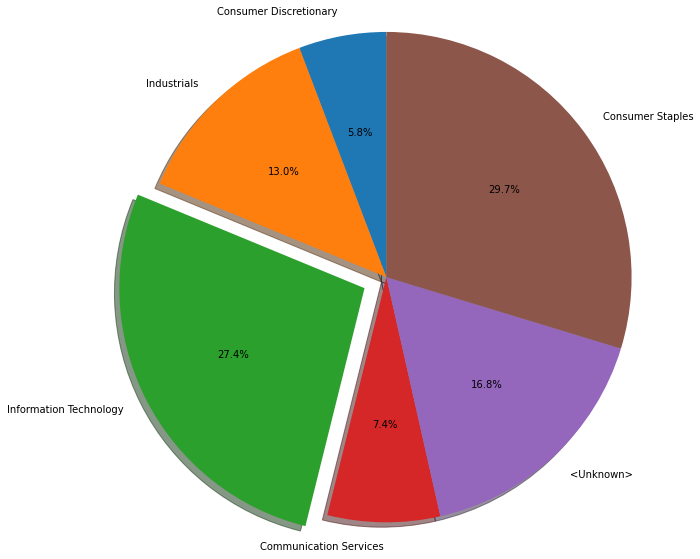

In [29]:
aggregation_api = api_factory.build(AggregationApi)

def chart_exposure(aggregation_api, effective_at, exposure_by, interest, scope, portfolio_code):
    """
    This function retrieves and charts the exposure of the Portofolio
    
    :param: aggreagation_api: The LUSID aggregation API to use
    :param: effective_at: The effective at date to chart the exposure
    :param: exposure_by: The metric to chart exposure by e.g. GICSSector
    :param: interest: The area of interest e.g. Information Technology, this will explode on the chart
    :param: scope: The scope of the Portfolio to look at exposure for
    :param: portfolio_code: The code of the Portfolio to look at exposure for
    """
    
    aggregation_request = AggregationRequest(
        recipe_id=ResourceId(
            scope=scope,
            code='default'),
        effective_at=us_tz.localize(effective_at).astimezone(pytz.UTC),
        metrics=[
            AggregateSpec(key='Holding/default/PV',
            op='Sum'),
            AggregateSpec(key=f'Instrument/{scope}/{exposure_by}',
            op='Value')
        ],
        group_by=[
            f'Instrument/{scope}/{exposure_by}'
        ])

    response = aggregation_api.get_aggregation_by_portfolio(
        scope=scope,
        code=portfolio_code,
        request=aggregation_request)

    labels = [result[f'Instrument/{scope}/{exposure_by}'] for result in response.data]
    values = [result['Sum(Holding/default/PV)'] for result in response.data]
    
    explode = [0] * len(labels)
    index = labels.index(interest)
    explode[index] = 0.1

    fig1, ax1 = plt.subplots(figsize=(10,10))
    ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')

    plt.show()
    
chart_exposure(aggregation_api, datetime(2020, 4, 28, 13), "GICSSector", "Information Technology", scope, ibor_portfolio_code)

#### Current Exposure by Country

You are not permitted to have more than 60% exposure to the US.

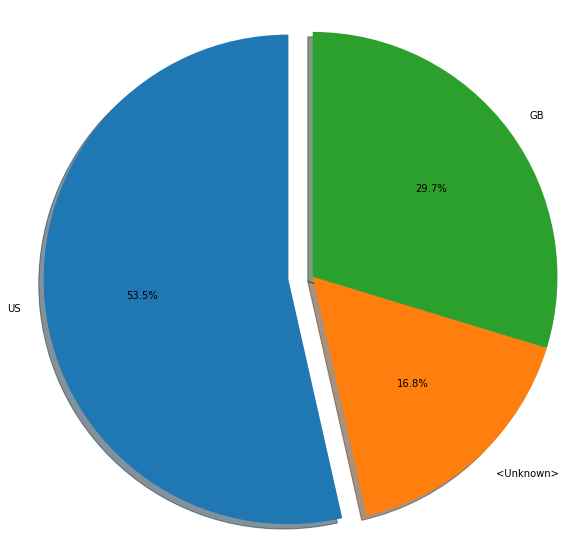

In [30]:
chart_exposure(
    aggregation_api, 
    datetime(2020, 4, 28, 13), 
    "CountryCode", 
    "US", 
    scope, 
    ibor_portfolio_code
)

#### Simulate the Transaction

In [31]:
derived_transaction_portfolios_api = api_factory.build(DerivedTransactionPortfoliosApi)
nflx_simulated_ibor_portfolio_code = "IBOR-NFLX-Trade-Simulation"


try: 
    derived_transaction_portfolios_api.create_derived_portfolio(
        scope=scope,
        portfolio=CreateDerivedTransactionPortfolioRequest(
            display_name="NFLXTradeSimulation",
            created=ibor_portfolio_creation_date,
            code=nflx_simulated_ibor_portfolio_code,
            parent_portfolio_id=ResourceId(
                scope=scope,
                code=ibor_portfolio_code)
        )
    )
    
except ApiException as e:
    print(json.loads(e.body)["title"])

response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=transactions,
    mapping_required={
        "code": f"${nflx_simulated_ibor_portfolio_code}",
        "transaction_id": "Id",
        "type": "TransactionType",
        "transaction_date": "$2020-04-28T17:00:00Z",
        "settlement_date": "$2020-05-01T17:00:00Z",
        "units": "Units",
        "total_consideration.amount": "Cost",
        "total_consideration.currency": "SettlementCurrency"
    },
    mapping_optional={
        "transaction_price.price": "Price",
        "transaction_price.type": "$Price",
        "transaction_currency": "TransactionCurrency"
    },
    identifier_mapping={
        "Ticker": "Ticker",
        "Figi": "Figi",
    },
    file_type="transactions"
)

succ, errors = format_transactions_response(response)
pd.DataFrame(data=[{"success": len(succ), "errors": len(errors)}])

,success,errors
0,1,0


#### Simulated Exposure by GICS Sector

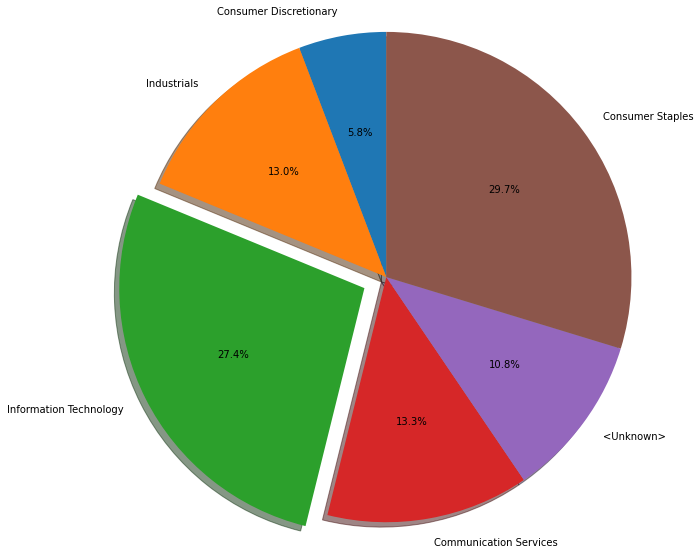

In [32]:
chart_exposure(
    aggregation_api, 
    datetime(2020, 4, 28, 14), 
    "GICSSector", 
    "Information Technology", 
    scope, 
    nflx_simulated_ibor_portfolio_code
)

#### Simulated Exposure by Country

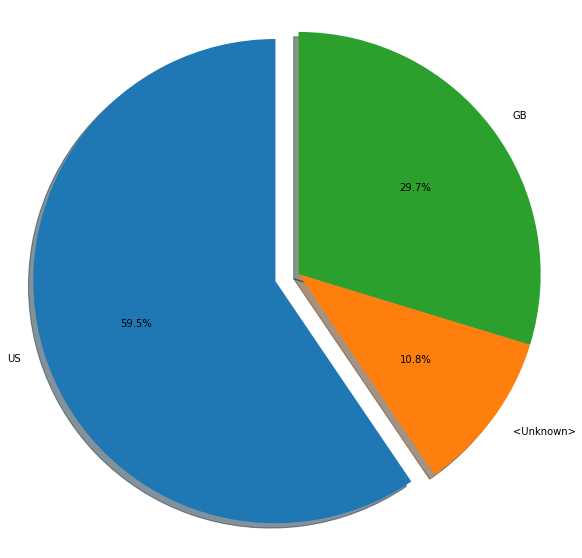

In [33]:
chart_exposure(
    aggregation_api, 
    datetime(2020, 4, 28, 14), 
    "CountryCode", 
    "US", 
    scope, 
    nflx_simulated_ibor_portfolio_code
)

#### Make the Trade for Real

In [34]:
response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=transactions,
    mapping_required={
        "code": f"${ibor_portfolio_code}",
        "transaction_id": "Id",
        "type": "TransactionType",
        "transaction_date": "$2020-04-28T15:00:00Z",
        "settlement_date": "$2020-04-30T15:00:00Z",
        "units": "Units",
        "total_consideration.amount": "Cost",
        "total_consideration.currency": "SettlementCurrency"
    },
    mapping_optional={
        "transaction_price.price": "Price",
        "transaction_price.type": "$Price",
        "transaction_currency": "TransactionCurrency"
    },
    identifier_mapping={
        "Ticker": "Ticker",
        "Figi": "Figi",
    },
    file_type="transactions"
)

succ, errors = format_transactions_response(response)
pd.DataFrame(data=[{"success": len(succ), "errors": len(errors)}])

,success,errors
0,1,0


In [35]:
get_holdings(datetime(2020, 4, 28, 11), scope, ibor_portfolio_code)

,instrument_uid,sub_holding_keys,Name(default-Properties),Figi(default-Properties),SourcePortfolioId(default-Properties),SourcePortfolioScope(default-Properties),holding_type,units,settled_units,cost.amount,...,transaction.exchange_rate,transaction.transaction_currency,transaction.properties.Transaction/IBORUserJourney/InvestorId.key,transaction.properties.Transaction/IBORUserJourney/InvestorId.value.label_value,transaction.instrument_identifiers.Instrument/default/Ticker,transaction.instrument_identifiers.Instrument/default/Figi,transaction.properties.Transaction/IBORUserJourney/Broker.key,transaction.properties.Transaction/IBORUserJourney/Broker.value.label_value,transaction.properties.Transaction/default/ResultantHolding.key,transaction.properties.Transaction/default/ResultantHolding.value.metric_value.value
0,LUID_LWZVWS8K,{},AMAZON.COM INC,BBG000BVPV84,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,4714.00,6819.0,10752445.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LUID_O6YO5U8M,{},GENERAL ELECTRIC CO,BBG000BK6MB5,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,3919130.00,3919130.0,22428005.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LUID_GPBJSHZU,{},APPLE INC,BBG000B9XRY4,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,133369.00,120776.0,34691739.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LUID_IQROB9HG,{},MICROSOFT CORP,BBG000BPH459,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,87759.00,67223.0,14139580.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LUID_JHHSAU3V,{},FACEBOOK INC-CLASS A,BBG000MM2P62,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,33600.00,33600.0,6930000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LUID_OTU0MUPV,{},NETFLIX INC,BBG000CL9VN6,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,44402.00,17087.0,19270938.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,LUID_QT9MRWRJ,{},MSFT Convertible Bond,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,0.00,2567.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LUID_1WRQVQE7,{},FB Rights Issuance,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,4616.00,4616.0,999133.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,LUID_4OM40OZQ,{},TESCO PLC,BBG000BF46Y8,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,19715510.00,19715510.0,40048509.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,LUID_QKO6C2PR,{},IRSFixed3ToFloatLIBOR30,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,1.00,1.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2:00pm - I want to enter into an IRS with a given counterparty, What is my counterparty exposure right now? What is the risk level of this counterparty?

Upsert IRS security

How to calculate exposure?
What is risk level in this context?

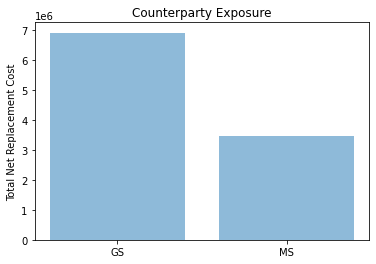

In [36]:
# Get holdings with counteryparty related properties 
response = transaction_portfolios_api.get_holdings(
    scope=scope,
    code=ibor_portfolio_code,
    effective_at=us_tz.localize(datetime(2020, 4, 28, 13)).astimezone(pytz.UTC),
    property_keys=[
        f"Instrument/{scope}/SecurityType",
        f"Instrument/{scope}/CounterParty",
        f"Instrument/{scope}/ReplacementCost"
    ]
)

# Filter to relevant over the counter (OTC) contracts
otc_holdings = [holding for holding in response.values if holding.properties.get(
    f'Instrument/{scope}/SecurityType', None) is not None]

otc_holdings = [holding for holding in otc_holdings if holding.properties.get(
    f'Instrument/{scope}/SecurityType', None).value.label_value == "Interest Rate Swap" ]

# Determine counterparty exposure
counterparty_exposure = {}

for holding in otc_holdings:
    counterparty_exposure.setdefault(holding.properties[f"Instrument/{scope}/CounterParty"].value.label_value, []).append(
        holding.properties[f"Instrument/{scope}/ReplacementCost"].value.metric_value.value)
    
counterparty_exposure = {counterparty: sum(replacement_costs) for counterparty, replacement_costs in counterparty_exposure.items()}

# Chart results
y_pos = np.arange(len(counterparty_exposure.keys()))
plt.bar(y_pos, list(counterparty_exposure.values()), align='center', alpha=0.5)
plt.xticks(y_pos, list(counterparty_exposure.keys()))
plt.ylabel('Total Net Replacement Cost')
plt.title('Counterparty Exposure')
plt.show()

## 4:15pm - Buy more convertible MSFT debt

Buy MSFT convertible bond

In [37]:
transactions = pd.read_csv("./data/IBORFlows_Transactions_1615.csv")
transactions.head()

,Name,Units,TransactionType,ClientInternal,Cost,Price,Id,Date,SettlementDate,TransactionCurrency,SettlementCurrency
0,MSFT Convertible Bond,2326,Buy,MFST1.25,3450062.76,1483.26,KMJYU24XL,2020-04-28T16:15:00-04:00,2020-04-30T16:15:00-04:00,USD,USD


In [38]:
response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=transactions,
    mapping_required={
        "code": f"${ibor_portfolio_code}",
        "transaction_id": "Id",
        "type": "TransactionType",
        "transaction_date": "$2020-04-28T20:15:00Z",
        "settlement_date": "$2020-04-30T20:15:00Z",
        "units": "Units",
        "total_consideration.amount": "Cost",
        "total_consideration.currency": "SettlementCurrency"
    },
    mapping_optional={
        "transaction_price.price": "Price",
        "transaction_price.type": "$Price",
        "transaction_currency": "TransactionCurrency",
    },
    identifier_mapping={
        "ClientInternal": "ClientInternal"
    },
    file_type="transactions"
)

succ, errors = format_transactions_response(response)
pd.DataFrame(data=[{"success": len(succ), "errors": len(errors)}])

,success,errors
0,1,0


In [39]:
get_holdings(datetime(2020, 4, 28, 16, 15), scope, ibor_portfolio_code)

,instrument_uid,sub_holding_keys,Name(default-Properties),Figi(default-Properties),SourcePortfolioId(default-Properties),SourcePortfolioScope(default-Properties),holding_type,units,settled_units,cost.amount,...,transaction.transaction_currency,transaction.properties.Transaction/IBORUserJourney/InvestorId.key,transaction.properties.Transaction/IBORUserJourney/InvestorId.value.label_value,transaction.instrument_identifiers.Instrument/default/Ticker,transaction.instrument_identifiers.Instrument/default/Figi,transaction.properties.Transaction/IBORUserJourney/Broker.key,transaction.properties.Transaction/IBORUserJourney/Broker.value.label_value,transaction.properties.Transaction/default/ResultantHolding.key,transaction.properties.Transaction/default/ResultantHolding.value.metric_value.value,transaction.instrument_identifiers.Instrument/default/ClientInternal
0,LUID_LWZVWS8K,{},AMAZON.COM INC,BBG000BVPV84,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,4714.00,6819.0,10752445.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LUID_O6YO5U8M,{},GENERAL ELECTRIC CO,BBG000BK6MB5,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,3919130.00,3919130.0,22428005.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LUID_GPBJSHZU,{},APPLE INC,BBG000B9XRY4,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,133369.00,120776.0,34691739.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LUID_IQROB9HG,{},MICROSOFT CORP,BBG000BPH459,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,87759.00,67223.0,14139580.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LUID_JHHSAU3V,{},FACEBOOK INC-CLASS A,BBG000MM2P62,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,38216.00,33600.0,7929133.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LUID_OTU0MUPV,{},NETFLIX INC,BBG000CL9VN6,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,44402.00,17087.0,19270938.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,LUID_QT9MRWRJ,{},MSFT Convertible Bond,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,2326.00,2567.0,3450062.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LUID_1WRQVQE7,{},FB Rights Issuance,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,0.00,4616.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,LUID_4OM40OZQ,{},TESCO PLC,BBG000BF46Y8,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,19715510.00,19715510.0,40048509.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,LUID_QKO6C2PR,{},IRSFixed3ToFloatLIBOR30,NaN,IBOR-3888-7348-0bb8-06,IBORUserJourney,P,1.00,1.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EOD Trading - How much committed unsettled cash do I have? For how long? I want to park that in a money market account.

- Get Holdings & produce cash ladder

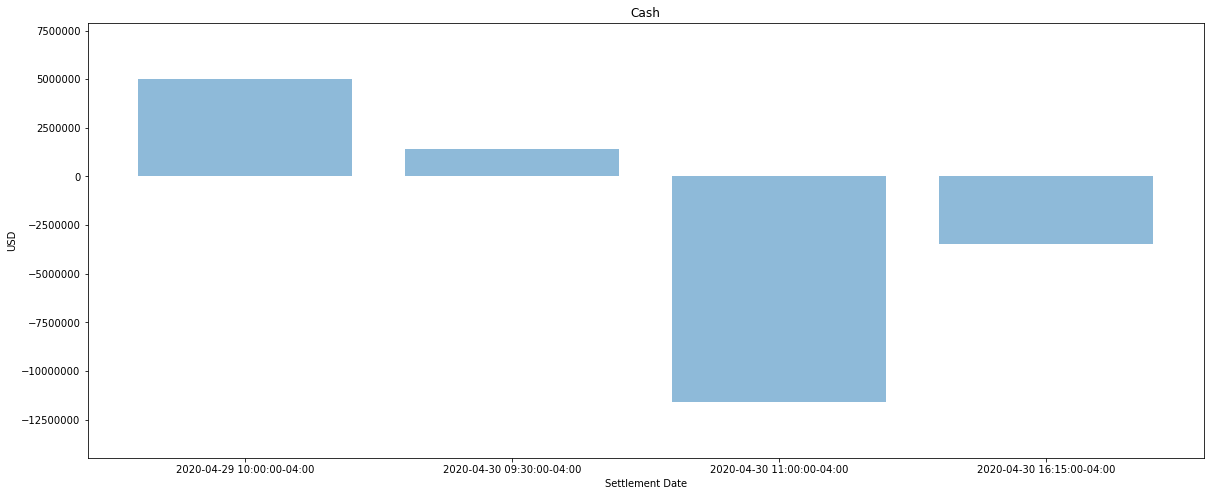

In [40]:
response = transaction_portfolios_api.get_holdings(
    scope=scope,
    code=ibor_portfolio_code,
    effective_at=us_tz.localize(datetime(2020, 4, 28, 17)).astimezone(pytz.UTC),
)

cash_positions = [holding for holding in response.values if "CCY_" in holding.instrument_uid and holding.holding_type != "B"]

settle_amounts = {}

for holding in cash_positions:
    settle_amounts.setdefault(f"{holding.cost.currency}@{holding.transaction.settlement_date}", []).append(
        holding.cost.amount)

settle_amounts = {key: sum(value) for key, value in settle_amounts.items()} 
settle_amounts


x = [datetime.strptime(key.split("@")[1], "%Y-%m-%d %H:%M:%S%z").astimezone(us_tz) for key in list(settle_amounts.keys())]
y = [value for value in list(settle_amounts.values())]

# Chart results
fig, ax = plt.subplots(figsize=(20, 8))
y_pos = np.arange(len(x))
ax.bar(y_pos, y, align='center', alpha=0.5)
plt.ylim(min(y)-abs(min(y)/4), max(y)+abs(min(y))/4)
plt.xticks(y_pos, x)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.ylabel('USD')
plt.xlabel('Settlement Date')
plt.title('Cash')
plt.show()

## Day 2

## 8am - Start of day holdings from ABOR, reconcile with IBOR from yesterday at NAV level, NAV is off

Will ensure that you have the following loaded internally to support the start of day ABOR

- Market Data Quotes

Then you load in the start of day ABOR

- Upsert NAV to Results Store
- Conduct NAV reconciliation

#### Market Data Quotes

In [41]:
quotes = pd.read_csv("./data/IBORFlows_Quotes_28AprilClose.csv")

instruments_api = api_factory.build(InstrumentsApi)

# Resolve the quotes to the instrument in LUSID using the Lusid Instrument Id
quotes["LusidInstrumentId"] = quotes.apply(
    lambda x: instruments_api.get_instrument(identifier_type="Figi", identifier=x["FIGI"]).lusid_instrument_id 
              if not pd.isna(x["FIGI"]) else
              instruments_api.get_instrument(identifier_type="ClientInternal", identifier=x["ClientInternal"]).lusid_instrument_id
              if pd.isna(x["FXPair"]) else
              x["FXPair"],
    axis=1)

quotes["InstrumentIdType"] = quotes.apply(
    lambda x: "LusidInstrumentId" if pd.isna(x["FXPair"]) else "CurrencyPair",
    axis=1)

quotes.head(n=50)

,Name,Date,Close Price,Currency,FIGI,ISIN,ClientInternal,FXPair,LusidInstrumentId,InstrumentIdType
0,AMAZON.COM INC,2020-04-28T16:00:00-04:00,2.314080e+03,USD,BBG000BVPV84,US0231351067,NaN,NaN,LUID_LWZVWS8K,LusidInstrumentId
1,GENERAL ELECTRIC CO,2020-04-28T16:00:00-04:00,6.800000e+00,USD,BBG000BK6MB5,US3696041033,NaN,NaN,LUID_O6YO5U8M,LusidInstrumentId
2,APPLE INC,2020-04-28T16:00:00-04:00,2.785800e+02,USD,BBG000B9XRY4,US0378331005,NaN,NaN,LUID_GPBJSHZU,LusidInstrumentId
3,MICROSOFT CORP,2020-04-28T16:00:00-04:00,1.698100e+02,USD,BBG000BPH459,US5949181045,NaN,NaN,LUID_IQROB9HG,LusidInstrumentId
4,FACEBOOK INC-CLASS A,2020-04-28T16:00:00-04:00,1.829100e+02,USD,BBG000MM2P62,US30303M1027,NaN,NaN,LUID_JHHSAU3V,LusidInstrumentId
5,NETFLIX INC,2020-04-28T16:00:00-04:00,4.038300e+02,USD,BBG000CL9VN6,US64110L1061,NaN,NaN,LUID_OTU0MUPV,LusidInstrumentId
6,MSFT Convertible Bond,2020-04-28T16:00:00-04:00,1.048000e+03,USD,NaN,NaN,MFST1.25,NaN,LUID_QT9MRWRJ,LusidInstrumentId
7,FB Rights Issuance,2020-04-28T16:00:00-04:00,1.961000e+02,USD,NaN,NaN,FBRights2020_04_27,NaN,LUID_1WRQVQE7,LusidInstrumentId
8,TESCO PLC,2020-04-28T16:00:00-04:00,2.353000e+00,GBP,BBG000BF46Y8,GB0008847096,NaN,NaN,LUID_4OM40OZQ,LusidInstrumentId
9,GBP/USD,2020-04-28T16:00:00-04:00,1.243200e+00,Rate,NaN,NaN,NaN,GBP/USD,GBP/USD,CurrencyPair


In [42]:
response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=quotes,
    mapping_required={
        "quote_id.effective_at": "$2020-04-28T20:00:00Z",
        "quote_id.quote_series_id.instrument_id_type": "InstrumentIdType",
        "quote_id.quote_series_id.provider": "$Lusid",
        "quote_id.quote_series_id.field": "$mid",
        "quote_id.quote_series_id.quote_type": "$Price",
        "quote_id.quote_series_id.instrument_id": "LusidInstrumentId",
        "metric_value.unit": "Currency",
        "metric_value.value": "Close Price"
    },
    mapping_optional={
        "lineage": "$YahooFinance"
    },
    file_type="quotes"
)

succ, failed, errors = format_quotes_response(response)
pd.DataFrame(data=[{"success": len(succ), "failed": len(failed), "errors": len(errors)}])

,success,failed,errors
0,14,0,0


#### Upsert NAV to Results Store

In [43]:
abor_day2 = pd.read_csv("./data/IBORFlows_Day2ABORWithNAV.csv")
abor_day2.head(n=5)

,NAV,ValuationCurrency,Units,PortfolioCost,UnrealisedP&L,PortfolioCurrency,InstrumentName,ClientInternal,Figi,Ticker,Currency
0,15779711.52,USD,6819,15553866.24,225845.28,USD,AMAZON.COM INC,NaN,BBG000BVPV84,AMZN,NaN
1,33645778.08,USD,120776,31122127.33,2523650.75,USD,APPLE INC,NaN,BBG000B9XRY4,AAPL,NaN
2,5127864.00,USD,4893,2322416.24,2805447.76,USD,MSFT Convertible Bond,MFST1.25,NaN,NaN,NaN
3,11415137.63,USD,67223,11817164.78,-402027.15,USD,MICROSOFT CORP,NaN,BBG000BPH459,MSFT,NaN
4,6900243.21,USD,17087,7704128.46,-803885.25,USD,NETFLIX INC,NaN,BBG000CL9VN6,NFLX,NaN


In [44]:
results_api = api_factory.build(ResultsApi)

# Resolve each instrument to the unique instrument in LUSID
abor_day2["LusidInstrumentId"] = abor_day2.apply(
    lambda x: instruments_api.get_instrument(identifier_type="Figi", identifier=x["Figi"]).lusid_instrument_id 
              if not pd.isna(x["Figi"]) else
              instruments_api.get_instrument(identifier_type="ClientInternal", identifier=x["ClientInternal"]).lusid_instrument_id
              if pd.isna(x["Currency"]) else
              f"CCY_{x['Currency']}",
    axis=1)

# Rename the columns to support reconciliation
column_renamer = {
    "NAV": "Holding/default/PV",
    "Units": "Holding/default/Units",
    "PortfolioCost": "Holding/default/PortfolioCost",
    "InstrumentName": "Instrument/default/Name",
    "LusidInstrumentId": "Instrument/default/LusidInstrumentId",
    "ValuationCurrency": "Instrument/default/Currency"
}
abor_day2 = abor_day2.loc[:, list(column_renamer.keys())].rename(columns=column_renamer)

# Save then read the file as a CSV
abor_day2.to_csv("./data/IBORFlows_Day2ABORWithNAVLUIDS.csv", index=False)
with open("./data/IBORFlows_Day2ABORWithNAVLUIDS.csv", 'r') as myfile: 
    fdata = myfile.read()

# Upsert the results into LUSID
results_api.upsert_results(
    request=CreateResults(
        effective_at=us_tz.localize(datetime(2020, 4, 29, 8)).astimezone(pytz.utc),
        entity_scope=scope,
        entity_code=ibor_portfolio_code,
        calculation_scope=scope+"ABORNAV",
        calculation_code="default",
        format="Csv",
        data=fdata,
    )
)

print ("Loaded ABOR NAV data into LUSID")

Loaded ABOR NAV data into LUSID


#### Conduct NAV reconciliation

In [45]:
reconciliation_api = api_factory.build(ReconciliationsApi)

# Aggregation request for IBOR
ibor_aggregation_request = AggregationRequest(
    recipe_id=ResourceId(
        scope=scope,
        code='default'),
    effective_at=us_tz.localize(datetime(2020, 4, 29, 8)).astimezone(pytz.utc),
    metrics=[
        AggregateSpec(key='Holding/default/PV',
        op='Sum'),
        AggregateSpec(key='Holding/default/Units',
        op='Sum'),
        AggregateSpec(key='Holding/default/SubHoldingKey',
        op='Value'),
        AggregateSpec(key='Instrument/default/Currency',
        op='Value')
    ],
    group_by=[
        'Holding/default/SubHoldingKey'
    ],
    report_ccy="USD")

# Point the ABOR aggregation request to the recently upserted results
abor_aggregation_request = copy.deepcopy(ibor_aggregation_request)
abor_aggregation_request.recipe_id.scope = scope+"ABORNAV"

# Run reconciliation
response = reconciliation_api.reconcile_valuation(
    request=ValuationsReconciliationRequest(
        left=ValuationReconciliationRequest(
            portfolio_id=ResourceId(
                scope=scope,
                code=ibor_portfolio_code),
            aggregation=ibor_aggregation_request
        ),
        right=ValuationReconciliationRequest(
            portfolio_id=ResourceId(
                scope=scope,
                code=ibor_portfolio_code),
            aggregation=abor_aggregation_request
        ),
        instrument_property_keys=[]
))

# Filter results to where there are breaks and rename the columns
response_filtered = [rec_break for rec_break in response.values if rec_break.difference_units!=0]
df = lusid_response_to_data_frame(response_filtered, rename_properties=True, column_name_mapping={
    "left_units": "IBOR_units",
    "right_units": "ABOR_units",
    "left_cost.amount": "IBOR_NAV.amount",
    "left_cost.currency": "IBOR_NAV.currency",
    "right_cost.amount": "ABOR_NAV.amount",
    "right_cost.currency": "ABOR_NAV.currency",
    "difference_cost.amount": "difference_NAV.amount",
    "difference_cost.currency": "difference_NAV.currency"
})

# Retrieve the instrument name
df["instrument_name"] = df.apply(
    lambda x: instruments_api.get_instrument(
                identifier_type="LusidInstrumentId", identifier=x["instrument_uid"]).name
                if not "CCY" in x["instrument_uid"] else
                f"Cash {x['instrument_uid'].split('_')[1]}",                  
    axis=1)

df.head(n=20)

,instrument_uid,sub_holding_keys,IBOR_units,ABOR_units,difference_units,IBOR_NAV.amount,IBOR_NAV.currency,ABOR_NAV.amount,ABOR_NAV.currency,difference_NAV.amount,difference_NAV.currency,instrument_properties,instrument_name
0,LUID_LWZVWS8K,{},4714.00,6819.0,2105.00,1.090857e+07,USD,15779711.52,USD,4.871138e+06,USD,[],AMAZON.COM INC
1,LUID_GPBJSHZU,{},133369.00,120776.0,-12593.00,3.715394e+07,USD,33645778.08,USD,-3.508158e+06,USD,[],APPLE INC
2,LUID_IQROB9HG,{},87759.00,67223.0,-20536.00,1.490236e+07,USD,11415137.63,USD,-3.487218e+06,USD,[],MICROSOFT CORP
3,LUID_JHHSAU3V,{},38216.00,33600.0,-4616.00,6.990089e+06,USD,6145776.00,USD,-8.443126e+05,USD,[],FACEBOOK INC-CLASS A
4,LUID_OTU0MUPV,{},44402.00,17087.0,-27315.00,1.793086e+07,USD,6900243.21,USD,-1.103062e+07,USD,[],NETFLIX INC
5,LUID_QT9MRWRJ,{},2326.00,4893.0,2567.00,2.437648e+06,USD,5127864.00,USD,2.690216e+06,USD,[],MSFT Convertible Bond
6,LUID_1WRQVQE7,{},0.00,4616.0,4616.00,0.000000e+00,USD,905197.60,USD,9.051976e+05,USD,[],FB Rights Issuance
7,LUID_4OM40OZQ,{},19715510.00,0.0,-19715510.00,5.767279e+07,GBP,0.00,GBP,-5.767279e+07,GBP,[],TESCO PLC
8,LUID_4OM40OZQ,{},0.00,19715510.0,19715510.00,0.000000e+00,USD,57672787.74,USD,5.767279e+07,USD,[],TESCO PLC
9,CCY_USD,{},10587156.06,19175739.0,8588582.94,1.058716e+07,USD,19175739.00,USD,8.588583e+06,USD,[],Cash USD


## Are all positions showing up? Is cash lining up?

New injections/withdrawls confirmed? Cash from corporate actions/options correct?

In [46]:
response = transaction_portfolios_api.get_holdings(
    scope=scope,
    code=ibor_portfolio_code,
    effective_at=us_tz.localize(datetime(2020, 4, 29, 8)).astimezone(pytz.UTC)
)

settled_cash = sum([holding.units for holding in response.values if 
                      holding.instrument_uid == "CCY_USD" and
                      holding.holding_type == "B"])

unsettled_cash = sum([holding.units for holding in response.values if 
                      holding.instrument_uid == "CCY_USD" and
                      holding.holding_type != "B"])

print("USD${:,.2f}".format(settled_cash), "in settled cash")
print("USD${:,.2f}".format(unsettled_cash), "in unsettled cash")
print("USD${:,.2f}".format(settled_cash+unsettled_cash), "in total cash")

USD$19,175,739.00 in settled cash
USD$-8,588,582.94 in unsettled cash
USD$10,587,156.06 in total cash


In [47]:
unsettled_cash = [holding for holding in response.values if 
                      holding.instrument_uid == "CCY_USD" and
                      holding.holding_type != "B"]

lusid_response_to_data_frame(unsettled_cash, rename_properties=True)

,instrument_uid,sub_holding_keys,SourcePortfolioId(default-Properties),SourcePortfolioScope(default-Properties),holding_type,units,settled_units,cost.amount,cost.currency,cost_portfolio_ccy.amount,...,transaction.transaction_currency,transaction.properties.Transaction/IBORUserJourney/InvestorId.key,transaction.properties.Transaction/IBORUserJourney/InvestorId.value.label_value,transaction.instrument_identifiers.Instrument/default/Ticker,transaction.instrument_identifiers.Instrument/default/Figi,transaction.properties.Transaction/IBORUserJourney/Broker.key,transaction.properties.Transaction/IBORUserJourney/Broker.value.label_value,transaction.properties.Transaction/default/ResultantHolding.key,transaction.properties.Transaction/default/ResultantHolding.value.metric_value.value,transaction.instrument_identifiers.Instrument/default/ClientInternal
0,CCY_USD,{},IBOR-3888-7348-0bb8-06,IBORUserJourney,A,5000000.00,0.0,5000000.00,USD,0.0,...,USD,Transaction/IBORUserJourney/InvestorId,INV_SDFKJ32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CCY_USD,{},IBOR-3888-7348-0bb8-06,IBORUserJourney,C,4997901.50,0.0,4997901.50,USD,0.0,...,USD,NaN,NaN,AMZN,BBG000BVPV84,Transaction/IBORUserJourney/Broker,MS,Transaction/default/ResultantHolding,4714.0,NaN
2,CCY_USD,{},IBOR-3888-7348-0bb8-06,IBORUserJourney,C,-3569611.78,0.0,-3569611.78,USD,0.0,...,USD,NaN,NaN,AAPL,BBG000B9XRY4,Transaction/IBORUserJourney/Broker,GS,Transaction/default/ResultantHolding,133369.0,NaN
3,CCY_USD,{},IBOR-3888-7348-0bb8-06,IBORUserJourney,C,-11566809.90,0.0,-11566809.90,USD,0.0,...,USD,NaN,NaN,NFLX,BBG000CL9VN6,NaN,NaN,Transaction/default/ResultantHolding,44402.0,NaN
4,CCY_USD,{},IBOR-3888-7348-0bb8-06,IBORUserJourney,C,-3450062.76,0.0,-3450062.76,USD,0.0,...,USD,NaN,NaN,NaN,NaN,NaN,NaN,Transaction/default/ResultantHolding,2326.0,MFST1.25


#### Tear Down

In [48]:
portfolios_api = api_factory.build(PortfoliosApi)
corporate_actions_api = api_factory.build(CorporateActionSourcesApi)
nflx_simulated_ibor_portfolio_code = "IBOR-NFLX-Trade-Simulation"
portfolios_api.delete_portfolio(scope=scope, code=nflx_simulated_ibor_portfolio_code)
corporate_actions_api.delete_corporate_action_source(scope=scope, code="CorporateActionsStream")
portfolios_api.delete_portfolio(scope=scope, code=ibor_portfolio_code)
print ("Tear down complete")

Tear down complete
